In [49]:
!pip install azure-ai-textanalytics

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

#Key and enpoint from Azure Text Analytics API service
key = "f7c7c91cd70e493ea38521d1cbf698aa"
endpoint = "https://mediumapi.cognitiveservices.azure.com/"


In [127]:
#Creating the Azure authentication function
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

#Core function for running sentiment analysis
#Modified to fit our specific needs
#Added global variables we'll use later in this notebook
def sentiment_analysis_example(client,list_name): 
    global senti_results 
    senti_results = {'Positive':0,'Neutral':0,'Negative':0,'Unknown':0}
    global senti_errors
    senti_errors = []
    documents = list_name
    for row in documents:
        response = client.analyze_sentiment(documents = row)[0]
        try:
            if response.sentiment == "positive":
                senti_results['Positive'] += 1
            elif response.sentiment == "neutral":
                senti_results['Neutral'] += 1
            elif response.sentiment == "negative":
                senti_results['Negative'] +=1
            else:
                senti_results['Unknown'] +=1
        except:
            senti_errors.append(row)
    return(senti_results,senti_errors)

#Assigning authentication function to object
client = authenticate_client()


In [107]:
#Assign your filename to a variable
emailFile = 'BenSent.CSV'

#Display the first 5 rows of our CSV to inspect
#Notice encoding - this seemed to work for our CSV
email_data = pd.read_csv(emailFile,encoding='ISO 8859-1')
email_data.head()

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
0,Re: ACTION REQUIRED: Missing Timecard for w/e ...,Since they didn't go over timecard entries dur...,Ben Prescott,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,Derek Smith,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
1,Re: Missing skills on Resouce Request,I went through all the ones I've heard of and ...,Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Ryan Heringhaus,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,Dan Wittenberg;Mickey Weibeler;Krista Meschino,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX;EX;EX,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,Re: New Payroll Schedule - Missing Deposit,"Got it, looks like it just came through. Thank...",Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,Re: New Payroll Schedule - Missing Deposit,"Any update on this? \r\n\r\nRegards,\r\nBen\r\...",Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,Re: New Payroll Schedule - Missing Deposit,Thanks Michael. I have some others on my team...,Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


In [108]:
#Assign Body column to new object
email_body = email_data['Body']

#Display top 5 rows and the overall length of the series
print(email_body.head())
print(email_body.shape)

0    Since they didn't go over timecard entries dur...
1    I went through all the ones I've heard of and ...
2    Got it, looks like it just came through. Thank...
3    Any update on this? \r\n\r\nRegards,\r\nBen\r\...
4    Thanks Michael.  I have some others on my team...
Name: Body, dtype: object
(1675,)


In [109]:
#Removing \r and \n characters from strings
email_body = email_body.str.replace("\r","")
email_body = email_body.str.replace("\n","")

#Display top 5 rows and the overall length of the series
print(email_body.head())
print(email_body.shape)

0    Since they didn't go over timecard entries dur...
1    I went through all the ones I've heard of and ...
2    Got it, looks like it just came through. Thank...
3    Any update on this? Regards,BenOn Wed, Jan 15,...
4    Thanks Michael.  I have some others on my team...
Name: Body, dtype: object
(1675,)


In [110]:
#Removing trailing email threads after start of my email signature
split_df = email_body.str.partition("Regards")
print(split_df[0:3])
print(split_df.shape)

                                                   0        1  \
0  Since they didn't go over timecard entries dur...  Regards   
1  I went through all the ones I've heard of and ...  Regards   
2  Got it, looks like it just came through. Thank...  Regards   

                                                   2  
0  ,BenSent from my Verizon, Samsung Galaxy smart...  
1  ,BenOn Thu, Jan 16, 2020, 6:37 PM Ryan Heringh...  
2  ,BenOn Wed, Jan 15, 2020, 2:59 PM Michael Hoeh...  
(1675, 3)


In [111]:
#Removing extra fluff from partitioning
clean_col = split_df.drop(columns=[1,2]) #1 contains "Regards", 2 contains trailing text
#Removing rows with NaN - no data
clean_nan = clean_col.dropna()

print(clean_col.shape[0]) #Display before NaN removal
print(clean_nan.shape[0]) #Display before NaN removal

1675
1642


In [112]:
#Updating the primary column with name EmailBody
clean_nan = clean_nan.rename(columns={0:"EmailBody"})

#Remove emails with default out of office reply
clean_pto = clean_nan[~clean_nan.EmailBody.str.contains("Hello,I am currently")]

#Remove emails with a forwarded message
cleaned_df = clean_pto[~clean_pto.EmailBody.str.contains("---------- Forwarded message ---------")]

print(clean_nan.shape[0]) #Pre PTO count
print(clean_pto.shape[0]) #Post PTO count
print(cleaned_df.shape[0]) #Post fwd removal

1642
1460
1399


In [113]:
#Reviewing the new data
#Some rows still appear to be empty we'll clean this later.
print(cleaned_df)
print(cleaned_df.shape)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1399 rows x 1 columns]
(1399, 1)


In [114]:
#Considering we know we still have rows with no data, we'll replace the empty space with NaN
#We can see all visible rows with nothing now show NaN
cleaned_df['EmailBody'].replace(" ",np.nan,inplace=True)
print(cleaned_df)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1399 rows x 1 columns]


C:\Users\ben.prescott\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [115]:
#We can now find all rows with NaN and drop them using pd.dropna
cleaned_df = cleaned_df.dropna()
print(cleaned_df)
print(cleaned_df.shape)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1288 rows x 1 columns]
(1288, 1)


In [116]:
#Create an empty list to store values
#Iterate over each row in the dataframe and append it to the list

senti_list = []

for row in range((cleaned_df.shape[0])):
    senti_list.append(list(cleaned_df.iloc[row,:]))
    
#Length of list matches length of old df 
print(len(senti_list))

1288


In [128]:
#Trigger the sentiment analysis function, passing in our list of lists
sentiment = sentiment_analysis_example(client,senti_list)

In [133]:
print(senti_results)
print("\n")
print("Sentiment errors:",senti_errors)
print("Error count:",len(senti_errors))

{'Positive': 360, 'Neutral': 412, 'Negative': 149, 'Unknown': 356}


Sentiment errors: [['  '], ['  '], ['  '], ['  '], ['  '], [''], ['  '], [''], ['  '], ['  '], ['']]
Error count: 11


In [134]:
#Removing the errors from our list of lists
#Assigning to a new variable so we have the unmodified original
senti_cleaned = senti_list

for i in senti_errors:
    for row in senti_cleaned:
        if i == row:
            senti_cleaned.remove(row)
            
print(len(senti_cleaned))

1277


In [135]:
sentiment = sentiment_analysis_example(client,senti_cleaned)

In [136]:
print(senti_results)
print("\n")
print("Sentiment errors:",senti_errors)
print("Error count:",len(senti_errors))

{'Positive': 360, 'Neutral': 412, 'Negative': 149, 'Unknown': 356}


Sentiment errors: []
Error count: 0


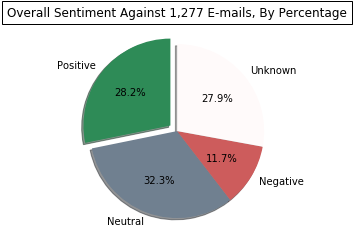

In [195]:
keys = senti_results.keys()
values = senti_results.values()
colors = ['seagreen','slategray','indianred','snow']
explode = (0.1, 0, 0, 0)
plt.pie(values,labels=keys,colors=colors, explode=explode,autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Overall Sentiment Against 1,277 E-mails, By Percentage',bbox={'facecolor':'1','pad':5})
plt.show()